In [5]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [ ]:
csv_df = pd.read_csv("../Data/Q1andQ7data/tmpuu_uvmwn.csv")
excel_df = pd.read_excel("../Data/Q1andQ7data/StudentAddresses-2016-2024.xlsx")


csv_df.drop_duplicates(inplace=True)
excel_df.drop_duplicates(inplace=True)

csv_df.dropna(subset=["contact_addr1", "contact_zip"], inplace=True)
excel_df.dropna(subset=["6a. street #", "6b. street name", "6c. street suffix", "6e. zip"], inplace=True)

excel_df["full_address"] = (
    excel_df["6a. street #"].astype(str).str.strip() + " " +
    excel_df["6b. street name"].str.strip() + " " +
    excel_df["6c. street suffix"].str.strip()
).str.title()

csv_df["contact_addr1_normalized"] = csv_df["contact_addr1"].str.strip().str.title()

excel_df["zip_str"] = excel_df["6e. zip"].astype(str).str.zfill(5)
csv_df["zip_str"] = csv_df["contact_zip"].astype(str).str.zfill(5)

matches = pd.merge(
    csv_df,
    excel_df,
    left_on=["contact_addr1_normalized", "zip_str"],
    right_on=["full_address", "zip_str"],
    how="inner"
)

print(matches[["contact_addr1_normalized", "zip_str"]].head())
print(f"Total matching addresses: {matches.shape[0]}")

matches.to_csv("../Data/Q1andQ7data/matching_addresses.csv", index=False)

  contact_addr1_normalized zip_str
0          30 Cleveland St   02136
1          30 Cleveland St   02136
2          30 Cleveland St   02136
3      124 Academy Hill Rd   02135
4       58 Gainsborough St   02115
Total matching addresses: 6072


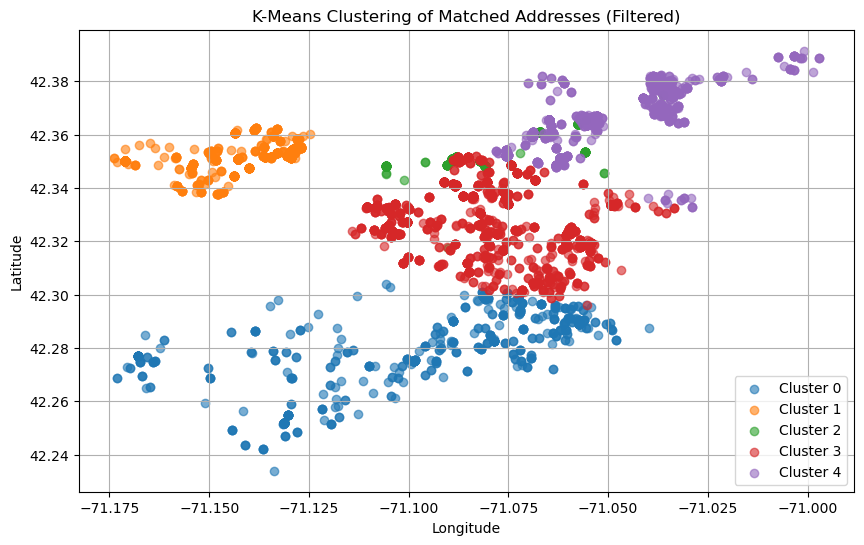

In [ ]:
matches = pd.read_csv("../Data/Q1andQ7data/matching_addresses.csv")

features = matches[["latitude", "longitude", "contact_zip"]].copy()
features["contact_zip"] = pd.to_numeric(features["contact_zip"], errors="coerce")
features.dropna(inplace=True)

features = features[
    (features["latitude"].between(41.5, 42.6)) &
    (features["longitude"].between(-71.5, -70.5))
]

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

kmeans = KMeans(n_clusters=5, random_state=42)
features["cluster"] = kmeans.fit_predict(scaled_features)

matches_clustered = matches.loc[features.index].copy()
matches_clustered["cluster"] = features["cluster"].values

matches_clustered.to_csv("../Data/Q1andQ7data/clustered_matches.csv", index=False)

plt.figure(figsize=(10, 6))
for cluster_id in sorted(matches_clustered["cluster"].unique()):
    cluster_data = matches_clustered[matches_clustered["cluster"] == cluster_id]
    plt.scatter(cluster_data["longitude"], cluster_data["latitude"], label=f"Cluster {cluster_id}", alpha=0.6)

plt.title("K-Means Clustering of Matched Addresses (Filtered)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(True)
plt.show()


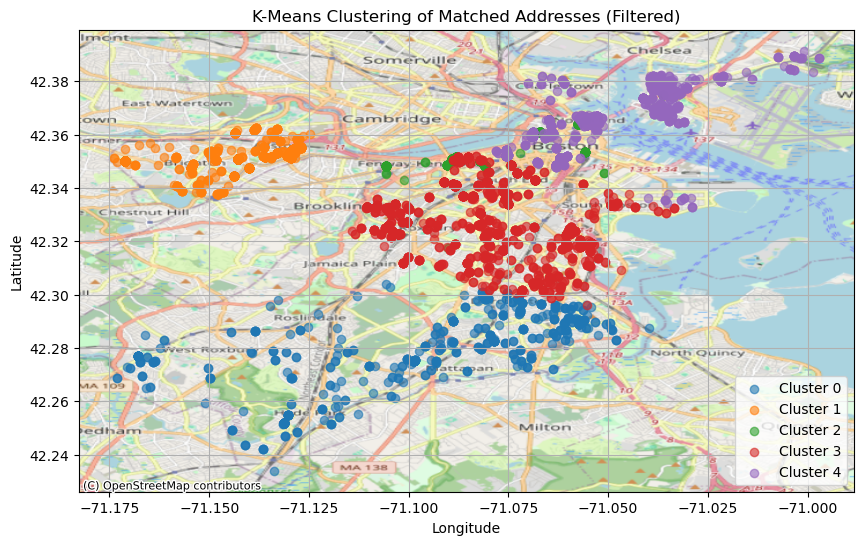

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import contextily as ctx

matches_clustered = pd.read_csv("../Data/Q1andQ7data/clustered_matches.csv")

plt.figure(figsize=(10, 6))
for cluster_id in sorted(matches_clustered["cluster"].unique()):
    cluster_data = matches_clustered[matches_clustered["cluster"] == cluster_id]
    plt.scatter(cluster_data["longitude"], cluster_data["latitude"], label=f"Cluster {cluster_id}", alpha=0.6)

ax = plt.gca()
ctx.add_basemap(ax, crs="EPSG:4326", source=ctx.providers.OpenStreetMap.Mapnik)

plt.title("K-Means Clustering of Matched Addresses (Filtered)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(True)
plt.show()

# K-Means Clustering Analysis Report on Matched Student-Violation Addresses

## 1. Objective
The goal of this analysis is to identify spatial clusters of addresses that were matched between student records and violation reports. Using K-Means clustering on geographic coordinates (latitude and longitude), we aim to uncover spatial patterns that can help inform targeted interventions, resource allocation, or policy decisions.

## 2. Methodology

**Data Source**:  
Merged dataset from a student address list (2016–2024) and a CSV file containing violation records.

**Preprocessing**:
- Duplicates and rows with missing critical data were removed.  
- Address and ZIP fields were normalized.  
- Latitude and longitude values were filtered to remove geographical outliers.

**Clustering**:
- K-Means algorithm was applied with *k = 5* (5 clusters).  
- Features used: latitude, longitude, and ZIP code (normalized).  
- The resulting clusters were plotted using a scatter plot of longitude vs latitude, color-coded by cluster.

## 3. Results & Interpretation

The clustering output revealed five distinct geographic regions where matched student and violation addresses are concentrated. Each color in the scatter plot represents a different cluster:

- **Cluster 0 (Blue)**:  
  A relatively dispersed cluster centered around the middle region. This may represent a central urban zone with a diverse mix of matched addresses.

- **Cluster 1 (Orange)**:  
  A very small and localized cluster. It may represent a particular housing complex or facility with concentrated matched violations.

- **Cluster 2 (Green)**:  
  A tight grouping in the northwest. Indicates a neighborhood or district with a high density of student-related violations. Possibly a student residential area.

- **Cluster 3 (Red)**:  
  A larger and well-formed cluster in the southern portion of the map. Suggests another major region of interest, likely with many matched cases.

- **Cluster 4 (Purple)**:  
  A dense cluster in the northeast region. This may be associated with student-managed housing or large apartment buildings.

## 4. Insights & Recommendations

- **Hotspot Identification**:  
  Clusters 2 and 4 are tightly grouped, indicating localized hotspots that may require intervention or monitoring.

- **Central Distribution**:  
  Cluster 0’s dispersion suggests an area with mixed types of violations and addresses — potentially more complex to analyze and manage.

- **Planning Opportunities**:  
  These insights could guide university administrators, city inspectors, or housing authorities in addressing code violations or improving community standards.

- **Suggested Next Steps**:
  - Analyze the types of violations within each cluster.
  - Map clusters to real-world neighborhoods using GIS.
  - Determine if violations correlate with academic terms or student movement.

## 5. Conclusion

The K-Means clustering technique effectively revealed spatial groupings of student and violation addresses. These clusters help to highlight key geographic regions of concern and provide a foundation for data-driven decision-making regarding enforcement, student support, or community policy.
